# 1️⃣ Import Libraries

In [2]:
from IPython.display import clear_output

%pip install kagglehub catboost lightgbm tqdm -q

clear_output()

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder ,MinMaxScaler
from sklearn.linear_model import Ridge, Lasso,LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as sklearn_mse, mean_absolute_error, r2_score
%matplotlib inline

# 2️⃣ Read the Data

In [4]:
path = kagglehub.dataset_download("amar5693/student-performance-dataset")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'student-performance-dataset' dataset.
Path to dataset files: /kaggle/input/student-performance-dataset


In [5]:
df=pd.read_csv(os.path.join(path,"ultimate_student_productivity_dataset_5000.csv"))

In [6]:
df.head()

,student_id,age,gender,academic_level,study_hours,self_study_hours,online_classes_hours,social_media_hours,gaming_hours,sleep_hours,...,exercise_minutes,caffeine_intake_mg,part_time_job,upcoming_deadline,internet_quality,mental_health_score,focus_index,burnout_level,productivity_score,exam_score
0,1,18,Other,High School,7.64,1.56,2.20,3.05,2.19,6.52,...,81,38,1,0,Good,10,43.05,31.77,73.65,50.16
1,2,18,Other,High School,2.21,2.22,2.10,1.65,2.55,5.97,...,111,339,0,0,Good,3,15.92,37.00,13.70,1.00
2,3,22,Male,High School,3.45,0.00,0.29,1.34,2.08,8.39,...,68,266,0,1,Good,8,27.39,34.37,45.15,18.30
3,4,17,Other,High School,5.75,2.08,3.01,2.27,2.20,6.31,...,113,480,1,1,Poor,3,22.31,77.31,20.92,9.37
4,5,19,Other,High School,6.83,1.72,3.33,2.65,0.70,8.01,...,121,24,1,0,Good,8,38.11,39.53,59.23,27.81


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   student_id            5000 non-null   int64  
 1   age                   5000 non-null   int64  
 2   gender                5000 non-null   object 
 3   academic_level        5000 non-null   object 
 4   study_hours           5000 non-null   float64
 5   self_study_hours      5000 non-null   float64
 6   online_classes_hours  5000 non-null   float64
 7   social_media_hours    5000 non-null   float64
 8   gaming_hours          5000 non-null   float64
 9   sleep_hours           5000 non-null   float64
 10  screen_time_hours     5000 non-null   float64
 11  exercise_minutes      5000 non-null   int64  
 12  caffeine_intake_mg    5000 non-null   int64  
 13  part_time_job         5000 non-null   int64  
 14  upcoming_deadline     5000 non-null   int64  
 15  internet_quality     

# 3️⃣ Exploratory Data Analysis (EDA)

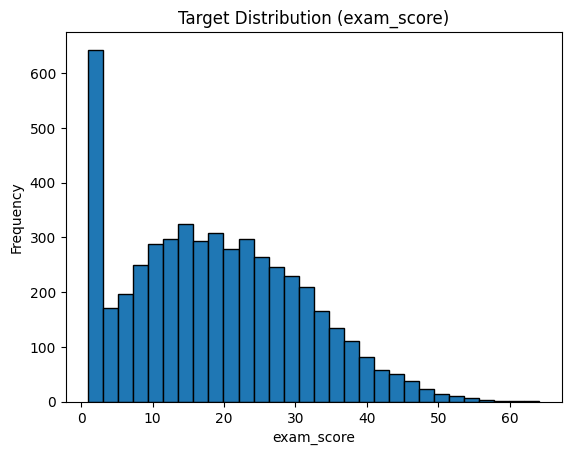

In [8]:
#Target Distribution
df["exam_score"].hist(bins=30, edgecolor='black')
plt.title(f"Target Distribution ({"exam_score"})")
plt.xlabel("exam_score")
plt.ylabel("Frequency")
plt.grid(False)

plt.show()

In [9]:
# check duplicate rows
df.duplicated().sum()

np.int64(0)

In [10]:
# check the mean and std for each column
df.describe()

,student_id,age,study_hours,self_study_hours,online_classes_hours,social_media_hours,gaming_hours,sleep_hours,screen_time_hours,exercise_minutes,caffeine_intake_mg,part_time_job,upcoming_deadline,mental_health_score,focus_index,burnout_level,productivity_score,exam_score
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2500.500000,20.520400,4.539594,2.478734,2.011984,2.998086,1.564514,7.016492,6.979588,74.535600,251.450400,0.498200,0.501400,5.507400,29.431616,45.615324,37.267716,18.803752
std,1443.520003,2.870406,1.821665,1.177990,0.983906,1.467949,1.110807,1.163692,2.486214,42.932293,143.842712,0.500047,0.500048,2.869145,9.962902,14.246591,16.849397,12.130840
min,1.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1250.750000,18.000000,3.250000,1.660000,1.320000,1.990000,0.670000,6.237500,5.280000,37.000000,129.000000,0.000000,0.000000,3.000000,22.567500,35.727500,25.290000,9.337500
50%,2500.500000,20.000000,4.530000,2.480000,2.010000,2.980000,1.490000,7.010000,6.950000,75.000000,252.000000,0.000000,1.000000,5.000000,29.430000,45.690000,36.860000,18.010000
75%,3750.250000,23.000000,5.760000,3.290000,2.690000,4.030000,2.340000,7.810000,8.710000,112.000000,376.000000,1.000000,1.000000,8.000000,36.242500,55.352500,49.142500,27.400000
max,5000.000000,25.000000,11.840000,7.410000,6.000000,8.280000,5.640000,10.000000,15.300000,149.000000,499.000000,1.000000,1.000000,10.000000,63.480000,97.580000,98.020000,64.090000


In [11]:
#check missing values
print(df.isna().sum())
#handeling missleading values
print(df["gender"].value_counts())
print(df["academic_level"].value_counts())
print(df["internet_quality"].value_counts())
# the value 'other' in gender column is a missleading value
# i will drop the rows that have this value
df=df[df["gender"]!="other"]

student_id              0
age                     0
gender                  0
academic_level          0
study_hours             0
self_study_hours        0
online_classes_hours    0
social_media_hours      0
gaming_hours            0
sleep_hours             0
screen_time_hours       0
exercise_minutes        0
caffeine_intake_mg      0
part_time_job           0
upcoming_deadline       0
internet_quality        0
mental_health_score     0
focus_index             0
burnout_level           0
productivity_score      0
exam_score              0
dtype: int64
gender
Male      1719
Other     1651
Female    1630
Name: count, dtype: int64
academic_level
Postgraduate     1687
High School      1672
Undergraduate    1641
Name: count, dtype: int64
internet_quality
Good       1722
Poor       1640
Average    1638
Name: count, dtype: int64


In [12]:
# check categorical columns
categorical_columns=df.select_dtypes(include=["object"]).columns
categorical_columns

Index(['gender', 'academic_level', 'internet_quality'], dtype='object')

In [13]:
# label encodeing categorical columns
labelEncoder=LabelEncoder()
for i in categorical_columns:
  df[i]=labelEncoder.fit_transform(df[i])

In [14]:
# feature scaling
minMaxScaler=MinMaxScaler()
X=df.drop(columns=["exam_score"],axis=1)
y=df["exam_score"]
# categorical columns don't need scailng
X_columns=X.columns.drop(['gender', 'academic_level', 'internet_quality'])
X[X_columns]=minMaxScaler.fit_transform(X[X_columns])

# 4️⃣ Feature selection

In [15]:
X_selected_columns=X.columns.drop(["student_id","upcoming_deadline","internet_quality"])
X=X[X_selected_columns]

# 5️⃣ Training Models

In [16]:
models = {
  "Ridge Regression": Ridge(alpha=0.9, max_iter=10008),
  "LASSO Regression": Lasso(alpha=0.8,  max_iter=10006),
  "Support Vector Machine": SVR(kernel='rbf'),
  "Decision Tree Regressor": DecisionTreeRegressor(max_depth=7),
  "Random Forest Regressor": RandomForestRegressor(n_estimators=200),
  "LightGBM": LGBMRegressor(verbose=-1),
  "CatBoost": CatBoostRegressor(verbose=0),
  "Linear Regression": LinearRegression()
}

In [17]:
all_results = {}

for name in models:
  all_results[name] = {'mse': [], 'rmse': [], 'r2': []}

In [18]:
n_splits = 5  # K=5 Folds

# 5-Fold Cross-Validation, shuffled
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

In [19]:
for fold_idx, (train_index, test_index) in enumerate(kf.split(X)):
  print(f"\nFold {fold_idx + 1}/{n_splits}")

  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  for model_name, model in models.items():
    print(f"Training {model_name}...")

    # Train the model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Calculate metrics
    mse = sklearn_mse(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Store results
    all_results[model_name]["mse"].append(mse)
    all_results[model_name]["rmse"].append(rmse)
    all_results[model_name]["r2"].append(r2)


Fold 1/5
Training Ridge Regression...
Training LASSO Regression...
Training Support Vector Machine...
Training Decision Tree Regressor...
Training Random Forest Regressor...
Training LightGBM...
Training CatBoost...
Training Linear Regression...

Fold 2/5
Training Ridge Regression...
Training LASSO Regression...
Training Support Vector Machine...
Training Decision Tree Regressor...
Training Random Forest Regressor...
Training LightGBM...
Training CatBoost...
Training Linear Regression...

Fold 3/5
Training Ridge Regression...
Training LASSO Regression...
Training Support Vector Machine...
Training Decision Tree Regressor...
Training Random Forest Regressor...
Training LightGBM...
Training CatBoost...
Training Linear Regression...

Fold 4/5
Training Ridge Regression...
Training LASSO Regression...
Training Support Vector Machine...
Training Decision Tree Regressor...
Training Random Forest Regressor...
Training LightGBM...
Training CatBoost...
Training Linear Regression...

Fold 5/5
Tr

# 6️⃣ Results Comparison

In [20]:
for model_name in all_results:
  print(f"\n{model_name}:")
  print(f"  MSE:  {np.mean(all_results[model_name]['mse']):.4f}")
  print(f"  RMSE: {np.mean(all_results[model_name]['rmse']):.4f}")
  print(f"  R2:    {np.mean(all_results[model_name]['r2']):.4f}")


Ridge Regression:
  MSE:  24.5668
  RMSE: 4.9553
  R2:    0.8323

LASSO Regression:
  MSE:  53.1106
  RMSE: 7.2858
  R2:    0.6384

Support Vector Machine:
  MSE:  28.7790
  RMSE: 5.3639
  R2:    0.8038

Decision Tree Regressor:
  MSE:  28.9083
  RMSE: 5.3751
  R2:    0.8024

Random Forest Regressor:
  MSE:  24.3841
  RMSE: 4.9362
  R2:    0.8334

LightGBM:
  MSE:  24.8770
  RMSE: 4.9862
  R2:    0.8301

CatBoost:
  MSE:  24.7954
  RMSE: 4.9773
  R2:    0.8306

Linear Regression:
  MSE:  24.5482
  RMSE: 4.9535
  R2:    0.8324


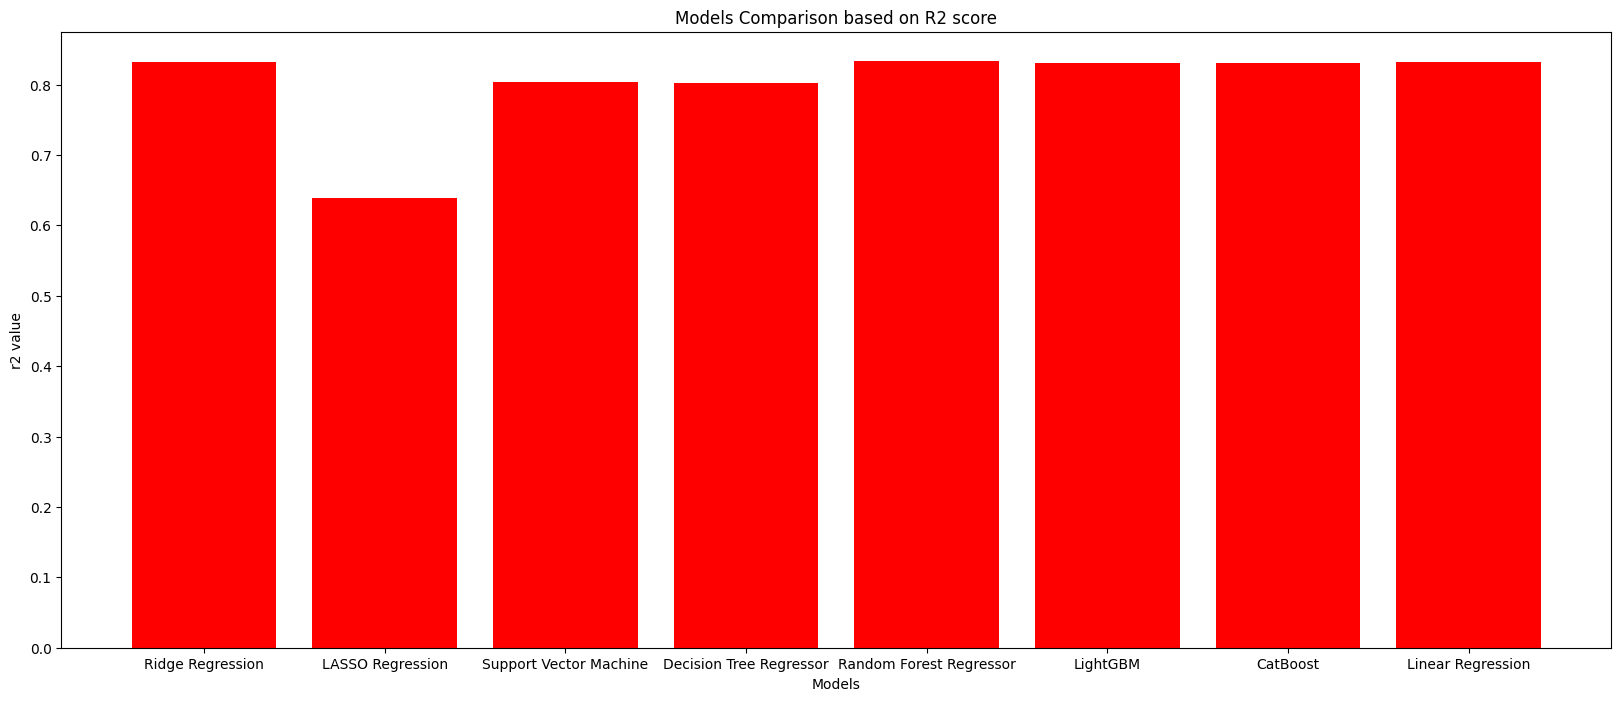

In [21]:
R2_mean=[np.mean(all_results[model_name]["r2"]) for model_name in all_results]
plt.figure(figsize=(20, 8))
plt.bar(list(all_results.keys()), height=R2_mean, color='red')
plt.xlabel('Models')
plt.ylabel('r2 value')
plt.title('Models Comparison based on R2 score')
plt.show()

# we notice that Random Forest Regressor is the best model for our data because we ploting using R2 score which means higher score is a better performance

# 7️⃣ Feature Importance Random Forest Regressor

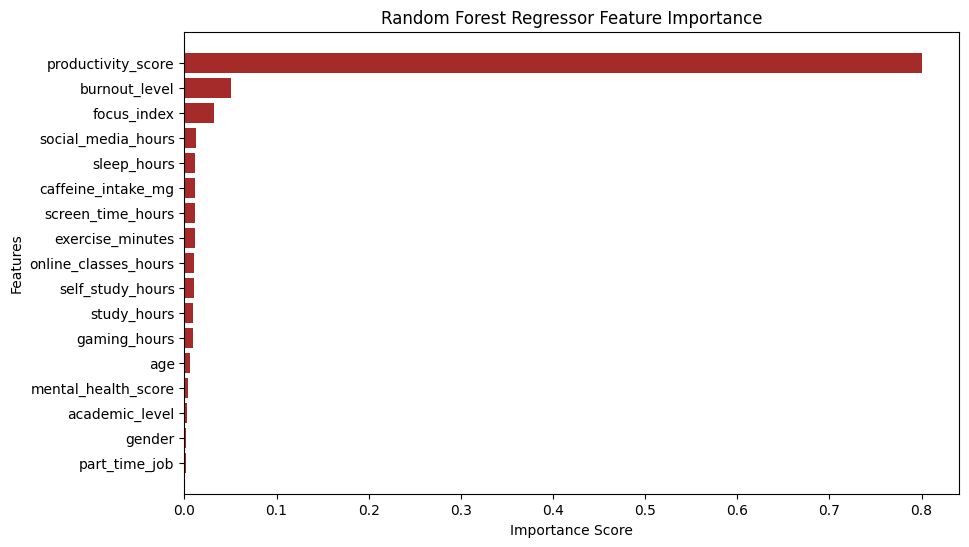

In [22]:
RFR_importances = models["Random Forest Regressor"].feature_importances_
# Create a sorted list of feature importance
sorted_idx = np.argsort(RFR_importances)[::-1]
sorted_features = X.columns[sorted_idx]
sorted_importances = RFR_importances[sorted_idx]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color='brown')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Random Forest Regressor Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()

# productivity_score is the most important feature